In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from six import StringIO
from graphviz import Digraph, nohtml
from sklearn.tree import export_graphviz
from IPython.display import Image  
import seaborn as sns
from textblob import TextBlob, Word, WordList 
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, mean_squared_error

# Part A: Data Preprocessing

In [2]:
og_gtd = pd.read_csv("../input/gtd/globalterrorismdb_0718dist.csv", encoding= 'ISO-8859-1', low_memory=False)
print(f"We can see our data has {og_gtd.shape[0]} observations and {og_gtd.shape[1]} variables")

We can see our data has 181691 observations and 135 variables


In [3]:
data_columns = [
    # ===== Binary Variables ===== 
                'extended', # Did the duration of the incident extend 24 hours?
                'vicinity', # Did the incident occur in the immediate vicinity of the city? Is 0 for IN city.
                'crit1', 'crit2', 'crit3', # The incident meets the criterion (1, 2, 3), described in the introduction.
                'doubtterr', # Is there doubt to wether the attack is an act of terrorism?
                'multiple', # Is this incident connected to other incident(s)? !! Consistently available since 1997 !!
                'success', # Has the attack reached its goal? Depends on type of attack.
                'suicide', # Did the perpetrator intend to escape alive?
                'claimed', # Was the attack claimed by an organised group?
                'property', # Is there evidence of property damage from the incident?
                'ishostkid', # Were there victims taken hostage or kidnapped?
    
    # ===== Continuous Variables =====
                'nkill', # Amount of confirmed kills.
                'nwound', # Amount of confirmed wounded.
    
    # ===== Categorical variables =====
                'country_txt', # Name of country.
                'region_txt', # Name of region.
                'attacktype1_txt', # Of what type was the attack? I.e. assassination, bombing or kidnapping.
                'targtype1_txt', # What target did the attack have? I.e. business, government or police.
                'weaptype1_txt', # What weapon was used?
    
    # ===== Descriptive Variables =====
                'gname', # Name of the organized group, if applicable.
                'summary', # Summary of the attack.    
]
gtd = og_gtd.loc[:, data_columns] # Only keep described columns.
display(gtd.isnull().sum().sort_values(ascending=False)[:20])

summary            66129
claimed            66120
nwound             16311
nkill              10313
ishostkid            178
doubtterr              1
multiple               1
gname                  0
weaptype1_txt          0
targtype1_txt          0
attacktype1_txt        0
region_txt             0
country_txt            0
extended               0
vicinity               0
suicide                0
success                0
crit3                  0
crit2                  0
crit1                  0
dtype: int64

### Random acts of violence should not be part of the data.

In [4]:
gtd = gtd[(gtd.crit1 == 1) & (gtd.crit2 == 1) & (gtd.crit3 == 1) & (gtd.doubtterr == 0)]

In [5]:
def categorize_perpetrators(column):
    '''
    This function reorganizes perpetrator groups based on their value_counts, perpetrator groups with
    less than 20 occurences are re-assigned to a new category called 'small_time_perpetrator'
    Parameter is of the type <pandas.core.series.Series>
    '''
    perpetrators_count = column.value_counts()
    small_time_perpetrator = perpetrators_count[perpetrators_count < 20].index.tolist()
    column = column.apply(lambda x: 'small time perpetrator' if x in small_time_perpetrator else x).astype(str)
    return column

In [6]:
gtd.gname = categorize_perpetrators(gtd.gname)
print('Perpetrators categorized!')

Perpetrators categorized!


#### we don't need those columns anymore, lets remove them

In [7]:
gtd.drop(['crit1', 'crit2', 'crit3','doubtterr'], axis=1, inplace=True)

#### Weapontype column contains very long name for vehicle -> shorten.

In [8]:
gtd.weaptype1_txt.replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
    'Vehicle', inplace = True)

In [9]:
print ('missing data : \n')
print (gtd.isnull().sum().sort_values(ascending = False))

missing data : 

summary            42062
claimed            42056
nwound             10954
nkill               6768
ishostkid            161
multiple               1
suicide                0
success                0
property               0
vicinity               0
country_txt            0
region_txt             0
attacktype1_txt        0
targtype1_txt          0
weaptype1_txt          0
gname                  0
extended               0
dtype: int64


#### nkill and nwound has a lot of null, replace with median and round

In [10]:
gtd.nkill.fillna(gtd.nkill.median(), inplace=True)
gtd.nwound.fillna(gtd.nwound.median(), inplace=True)


#### guncertain1 and ishostkid doesn't have a lot of nulls so we will replace them with 0

In [11]:
gtd.ishostkid.fillna(0, inplace = True)
gtd.multiple.fillna(0, inplace = True)


In [12]:
print ('missing data : \n')
print (gtd.isnull().sum().sort_values(ascending = False).head(4))

missing data : 

summary    42062
claimed    42056
nwound         0
gname          0
dtype: int64


#### change textual to lower case

In [13]:
gtd.gname = gtd.gname.str.lower()

#### create 2 new columns, 'casualties' (killed + wounded) and nclass (binary for casualties)

In [14]:
gtd['casualties'] = gtd.nkill + gtd.nwound
gtd['nclass'] = gtd.casualties.apply(lambda x: 0 if x == 0 else 1) 

In [15]:
print ('missing data : \n')
print (gtd.isnull().sum().sort_values(ascending = False).head(4))

missing data : 

summary        42062
claimed        42056
extended           0
country_txt        0
dtype: int64


In [16]:
gtd.describe()

,extended,vicinity,multiple,success,suicide,claimed,property,ishostkid,nkill,nwound,casualties,nclass
count,138879.000000,138879.000000,138879.000000,138879.000000,138879.000000,96823.000000,138879.000000,138879.000000,138879.000000,138879.000000,138879.000000,138879.000000
mean,0.049964,0.063487,0.154293,0.882567,0.038501,0.045000,-0.638304,0.062234,2.144478,3.270062,5.414541,0.582413
std,0.217872,0.284328,0.361230,0.321937,0.192403,1.081471,3.228839,0.470130,10.673049,39.036194,45.562379,0.493163
min,0.000000,-9.000000,0.000000,0.000000,0.000000,-9.000000,-9.000000,-9.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,4.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1384.000000,8191.000000,9574.000000,1.000000


#### we can see that ishostkid, vicinity, doubterr, claimed and property all have unknown values (-9), we will replace them with 0

In [17]:
gtd.vicinity.replace(-9, 0, inplace = True)
gtd.claimed.replace(-9, 0, inplace = True)
gtd.property.replace(-9, 0, inplace = True)
gtd.ishostkid.replace(-9, 0, inplace = True)

#### we need to remove months, days with value of 0. 

remove countries with less than 200 occurrences (for readability)

In [18]:
gtd = gtd.groupby('country_txt').filter(lambda x : len(x)>200)
gtd = gtd.groupby('gname').filter(lambda x : len(x)>50)

# Part B: Visualizations

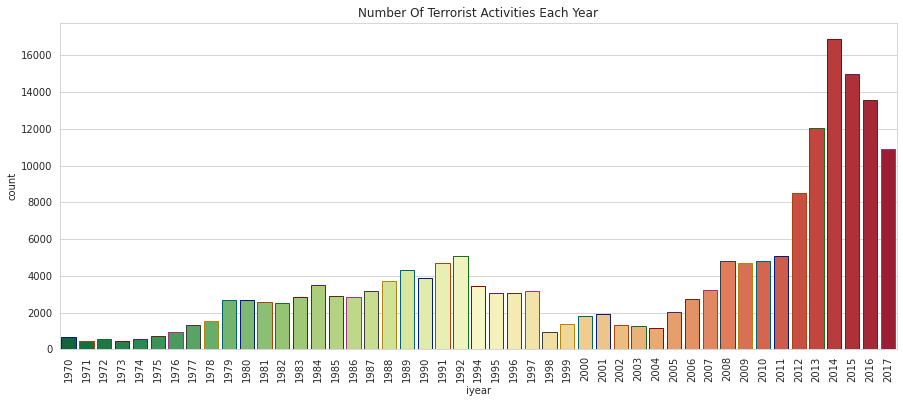

In [19]:
sns.set_style("whitegrid")
plt.subplots(figsize=(15,6))
sns.countplot(x='iyear',data=og_gtd,palette='RdYlGn_r',edgecolor=sns.color_palette('dark',10))
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities Each Year')
plt.show()

In this visual, we can see the low increase from 1970-1992, and afterward, there was a decrease in this attack until the rise which has started around 2004-2005 and increased severely until 2014. 

A logical explanation for the increase in the years of 2000s is the internet - the fact when different terror organizations and different terrorists could communicate and coordinate attacks all over the world, and also they can contact and impact new people for them to do these attacks.

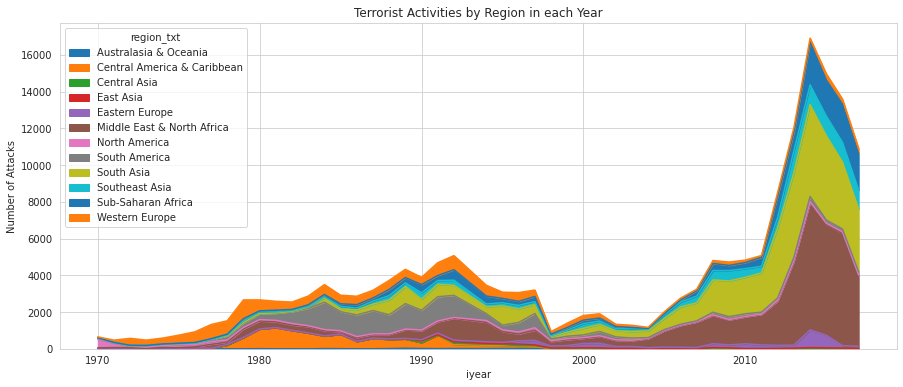

In [20]:
pd.crosstab(og_gtd.iyear, og_gtd.region_txt).plot(kind='area',figsize=(15,6))
plt.title('Terrorist Activities by Region in each Year')
plt.ylabel('Number of Attacks')
plt.show()

##### From this visual, we can see that between 1980-2000 most of the terror attacks around the world were mostly around South America, but since the beginning of 2000, they have almost completely gone.

##### Since around the year 2004, there was a massive ascend in the terror attacks all over the world, especially in the Middle East and in South Asia, when the pick of attacks was around 2013. Around this year we can as well see the increase in attacks around Eastern Europe, an area which before this year was rarely being attacked between the years of observations that we have.

##### All this increase of attacks around the world makes sense since that's around the time when ISIS appeared for the first time, and with the help social media that assisted to execute more attacks than they could have done in the past.

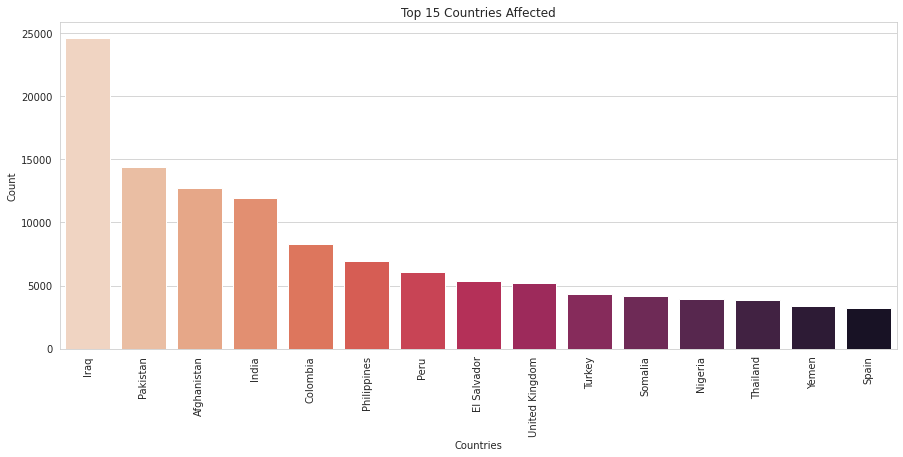

In [21]:
plt.subplots(figsize=(15,6))
sns.countplot(x=og_gtd['country_txt'],palette='rocket_r',order=og_gtd['country_txt'].value_counts()[:15].index)
plt.title('Top 15 Countries Affected')
plt.xlabel('Countries')
plt.ylabel('Count')
plt.xticks(rotation= 90)
plt.show()

##### We can see from this visual that besides UK and Spain, the other top 15 countries to be attacked are the developing countries, which we can also conclude that often countries with lower resources and ability to maintain their law and order, are more likely to be attacked because in this kind of countries usually the odds for the attacks to be successful are higher.

##### Furthermore, we can see that the top 3 countries being attacked are countries in which Islam is the main religion.

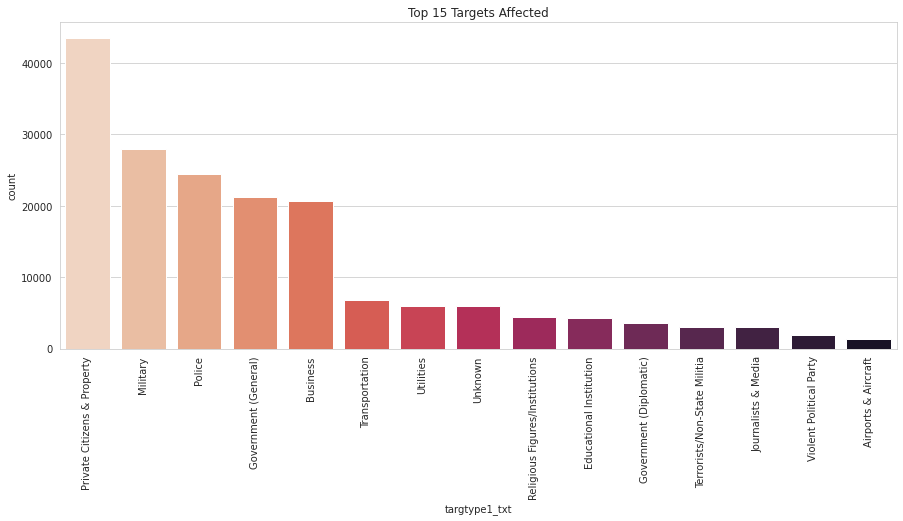

In [22]:
plt.subplots(figsize=(15,6))
sns.countplot(x=og_gtd['targtype1_txt'],palette='rocket_r',order=og_gtd['targtype1_txt'].value_counts()[:15].index)
plt.xticks(rotation=90)
plt.title('Top 15 Targets Affected')
plt.show()

##### We can see that terrorist's favorite target is private citizens and property. It makes sense since the fact that private citizens and properties are the most common to encounter, and as well the easiest one to hit and surprise without having the ability to respond.

##### Likewise, the top 3 targets after are the Military, Police, and Government. Also here, it is very reasonable that specifically that 3 targets are also there at the top since the fact these 3 institutions are the ones who try to fight the terror attacks the most.

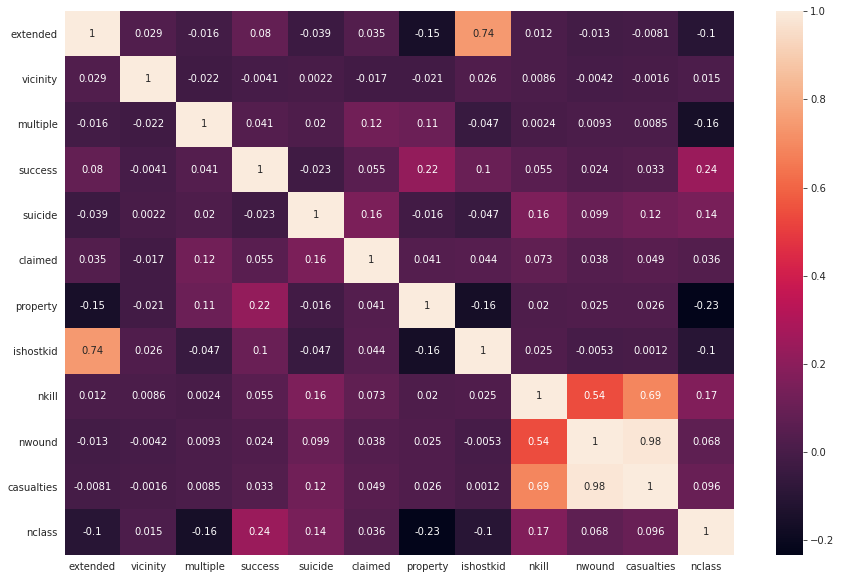

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(gtd.corr(), annot= True)
plt.show()

##### we can see high correlation between natlty1_cat and country_cat, it's reasonable based on the fact that most of the times the target of the attack is the same as the country it's taking place on.

##### moreover we can see high correlation between nwound and casualties, makes sense because the amount of people wounded has a direct connection to the number of casualties.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


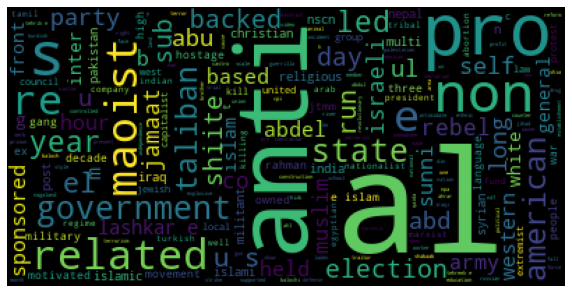

In [24]:
import nltk, codecs
from wordcloud import WordCloud, STOPWORDS
motive=og_gtd['motive'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words=nltk.tokenize.word_tokenize(motive)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black').generate(" ".join(words_except_stop_dist))
plt.imshow(wordcloud)
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.axis('off')
plt.show()

##### Stop Words: long, anti, related, electrion, government, abu, Taliban. All of these words are related to terrorism and the Arab world

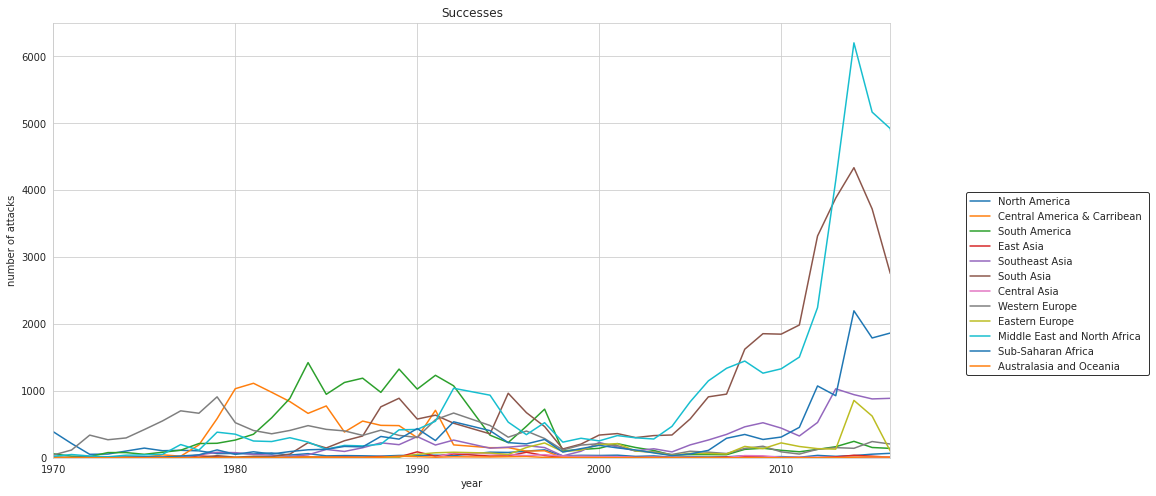

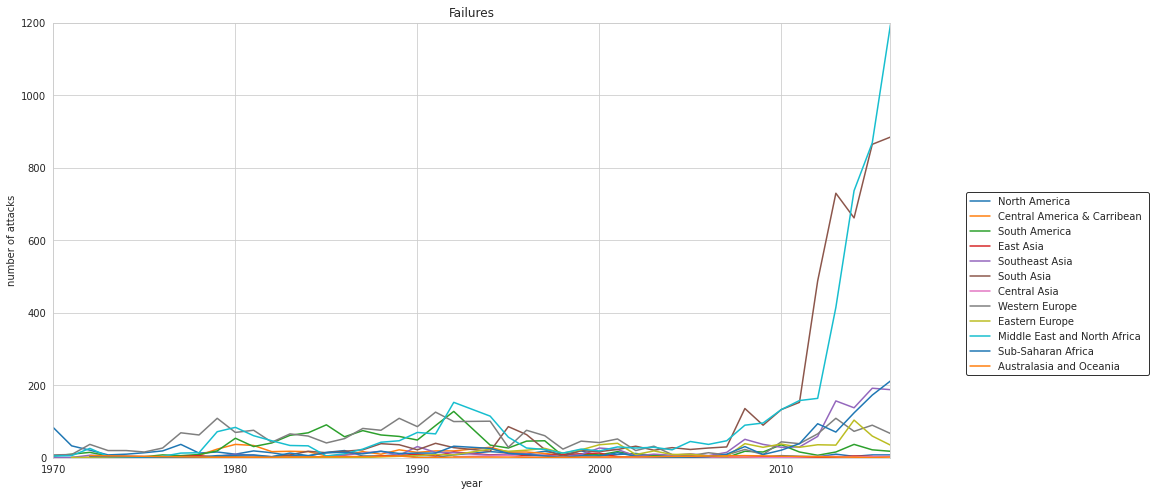

In [25]:
region_dictionary = {1: 'North America', 2: 'Central America & Carribean', 3: 'South America',
                     4: 'East Asia', 5: 'Southeast Asia', 6: 'South Asia', 7: 'Central Asia',
                     8: 'Western Europe', 9: 'Eastern Europe', 10: 'Middle East and North Africa',
                     11: 'Sub-Saharan Africa', 12: 'Australasia and Oceania'}

def multi_graph(result,result_list, xmin, xmax, ymin, ymax):
    fig2, ax2 = plt.subplots(figsize = (15,8))
    number = 1 #the for-loop in append_list processes the regions in order from 1 to 12
    for j in result_list:
        ax2.plot(j.index, j.eventid, label = '%s ' % region_dictionary[number] )
        number += 1

    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('year')
    plt.ylabel('number of attacks')
    plt.title(result)
    ax2.legend(loc = 'center', frameon = True, edgecolor = 'black',bbox_to_anchor =(1.2,0.4))


success_list = []
failure_list = []

for i in region_dictionary:
    region_data = og_gtd[(og_gtd.region == i)]
    region_data_success = region_data[(region_data.success == 1)]
    region_data_failure = region_data[(region_data.success == 0)]
    region_grouped_success = region_data_success.groupby('iyear').count()
    region_grouped_failure = region_data_failure.groupby('iyear').count()

    
    success_list.append(region_grouped_success)
    failure_list.append(region_grouped_failure)

multi_graph('Successes',success_list, 1970, 2016, 0, 6500)
multi_graph('Failures',failure_list, 1970, 2016, 0, 1200)


When we are looking at the 2 graphs, we can see the direct connection between the 2: In a very reasonable way, when there is an increase in the success of the attacks, there's also an increase in failures.

We can learn from this visual basically that the success rate for a terror attack has been stayed quite balance at most of the years, since the fact that we can see that almost in every year when there was an increase of success there was also increase of failures, which indicates that the main variant here is the number of attacks, and not differences in the quality of the attacks or major differences in the success rate during the years.

# Part C: Decision Tree

In [26]:
gtd = pd.get_dummies(gtd, columns=['country_txt'])
gtd = pd.get_dummies(gtd, columns=['attacktype1_txt'])
gtd = pd.get_dummies(gtd, columns=['targtype1_txt'])
gtd = pd.get_dummies(gtd, columns=['weaptype1_txt'])
gtd = pd.get_dummies(gtd, columns=['region_txt'])
gtd = pd.get_dummies(gtd, columns=['gname'])

In [27]:
cols = list(gtd.columns)
cols.remove('success')
cols.remove('claimed')
cols.remove('summary')
X = gtd[cols].copy()
y = gtd['success'].copy()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (103354, 294)
y_train shape:  (103354,)
X_test shape:  (25839, 294)
y_test shape:  (25839,)


In [29]:
y_train.value_counts()

1    91239
0    12115
Name: success, dtype: int64

In [30]:
def create_decision_tree_classifier(d, X, y):
    tree_clf = DecisionTreeClassifier(max_depth=d, min_samples_leaf=10, random_state=0)
    tree_clf = tree_clf.fit(X, y)
    return tree_clf

In [31]:
train_acc = []
train_recall = []
train_precision = []

test_acc = []
test_recall = []
test_precision = []

depth_range = range(1,21)
for d in depth_range:   
    tree_clf = create_decision_tree_classifier(d, X_train, y_train)

    y_pred = tree_clf.predict(X_train)
    
    train_acc.append(tree_clf.score(X_train, y_train))
    train_recall.append(recall_score(y_train, y_pred, average='binary'))
    train_precision.append(precision_score(y_train, y_pred, average='binary'))
    
    y_pred = tree_clf.predict(X_test)
    
    test_acc.append(tree_clf.score(X_test, y_test))
    test_recall.append(recall_score(y_test, y_pred, average='binary'))
    test_precision.append(precision_score(y_test, y_pred, average='binary'))


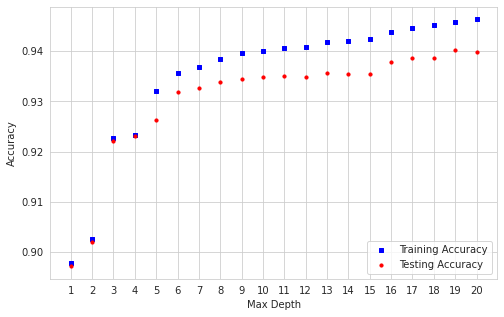

In [32]:
#plt.style.use('dark_background')
train_accuracies = pd.DataFrame({"Max Depth": depth_range, "Average Training Accuracy": train_acc})
test_accuracies = pd.DataFrame({"Max Depth": depth_range, "Average Testing Accuracy": test_acc})

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

ax1.scatter(range(1, 21), train_acc, s=10, c='b', marker="s", label='Training Accuracy')
ax1.scatter(range(1, 21) ,test_acc, s=10, c='r', marker="o", label='Testing Accuracy')

plt.xticks(np.arange(min(depth_range), max(depth_range)+1, 1.0))    

ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Max Depth")

plt.legend(loc='lower right')
plt.show()

In [33]:
optimal_depth = test_accuracies[test_accuracies["Average Testing Accuracy"] == test_accuracies["Average Testing Accuracy"].max()]["Max Depth"].values[0]
optimal_depth

19

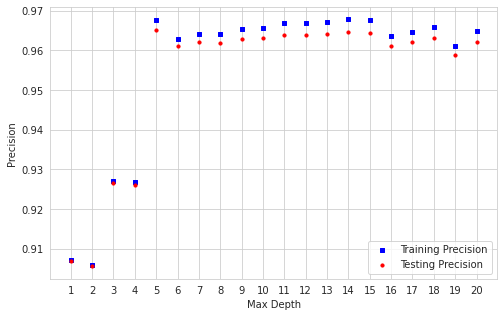

In [34]:
#plt.style.use('dark_background')
train_precisions = pd.DataFrame({"Max Depth": depth_range, "Average Training Accuracy": train_precision})
test_precisions = pd.DataFrame({"Max Depth": depth_range, "Average Testing Accuracy": test_precision})

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

ax1.scatter(range(1, 21), train_precision, s=10, c='b', marker="s", label='Training Precision')
ax1.scatter(range(1, 21) ,test_precision, s=10, c='r', marker="o", label='Testing Precision')

plt.xticks(np.arange(min(depth_range), max(depth_range)+1, 1.0))    

ax1.set_ylabel("Precision")
ax1.set_xlabel("Max Depth")

plt.legend(loc='lower right')
plt.show()

In [35]:
optimal_depth = test_precisions[test_precisions["Average Testing Accuracy"] == test_precisions["Average Testing Accuracy"].max()]["Max Depth"].values[0]
optimal_depth

5

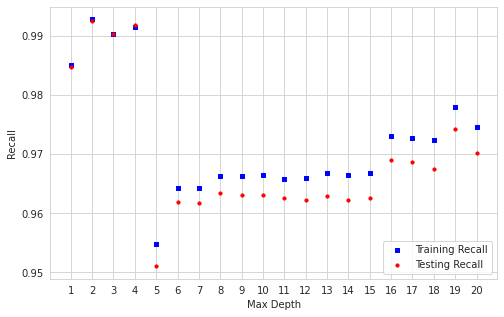

In [36]:
#plt.style.use('dark_background')
train_recalls = pd.DataFrame({"Max Depth": depth_range, "Average Training Accuracy": train_recall})
test_recalls = pd.DataFrame({"Max Depth": depth_range, "Average Testing Accuracy": test_recall})

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)

ax1.scatter(range(1, 21), train_recall, s=10, c='b', marker="s", label='Training Recall')
ax1.scatter(range(1, 21) ,test_recall, s=10, c='r', marker="o", label='Testing Recall')

plt.xticks(np.arange(min(depth_range), max(depth_range)+1, 1.0))    

ax1.set_ylabel("Recall")
ax1.set_xlabel("Max Depth")

plt.legend(loc='lower right')
plt.show()

In [37]:
optimal_depth = test_recalls[test_recalls["Average Testing Accuracy"] == test_recalls["Average Testing Accuracy"].max()]["Max Depth"].values[0]
optimal_depth

2

In [38]:
clf_tree = create_decision_tree_classifier(4, X_train, y_train)
test_pred = clf_tree.fit(X_train, y_train).predict(X_test)

print('Confusion matrix : \n',confusion_matrix(y_test,test_pred))
print('\nClassification Report : \n',classification_report(y_test, test_pred, target_names=['class 0', 'class 1']))
print('Root mean Squared error : ',np.sqrt(mean_squared_error(y_test, test_pred)))

Confusion matrix : 
 [[ 1217  1804]
 [  184 22634]]

Classification Report : 
               precision    recall  f1-score   support

     class 0       0.87      0.40      0.55      3021
     class 1       0.93      0.99      0.96     22818

    accuracy                           0.92     25839
   macro avg       0.90      0.70      0.75     25839
weighted avg       0.92      0.92      0.91     25839

Root mean Squared error :  0.27737693126039387


Text(0.5, 1.0, 'Feature Importance of Decision Tree')

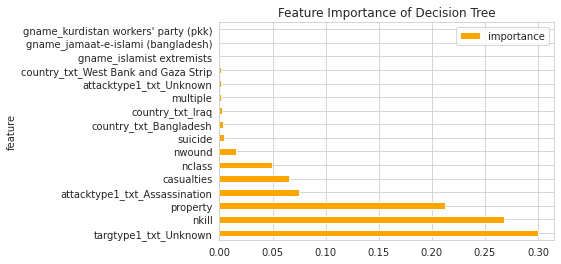

In [39]:
tree_clf = create_decision_tree_classifier(4, X_train, y_train)
importance = tree_clf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'feature':features, 'importance':importance})
for_graph = importance_df.sort_values('importance', ascending=False)[:16]
for_graph.plot(y='importance', x='feature', kind='barh', color='orange')
plt.title('Feature Importance of Decision Tree')

By this visual based on the Gini - we are checking between the whole leaves which leaf has the highest reduction and from that branch the tree will start. In our case it is the targtype_txt_Unkown.

#### using only most important features

In [40]:
X = gtd[['country_txt_Iraq', 'region_txt_Western Europe', 'weaptype1_txt_Explosives', 'multiple', 'suicide',
         'nwound', 'nclass', 'casualties', 'attacktype1_txt_Assassination',
         'ishostkid', 'property', 'nkill', 'targtype1_txt_Unknown']].copy()
y = gtd['success'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
tree_clf = create_decision_tree_classifier(4, X_train, y_train)

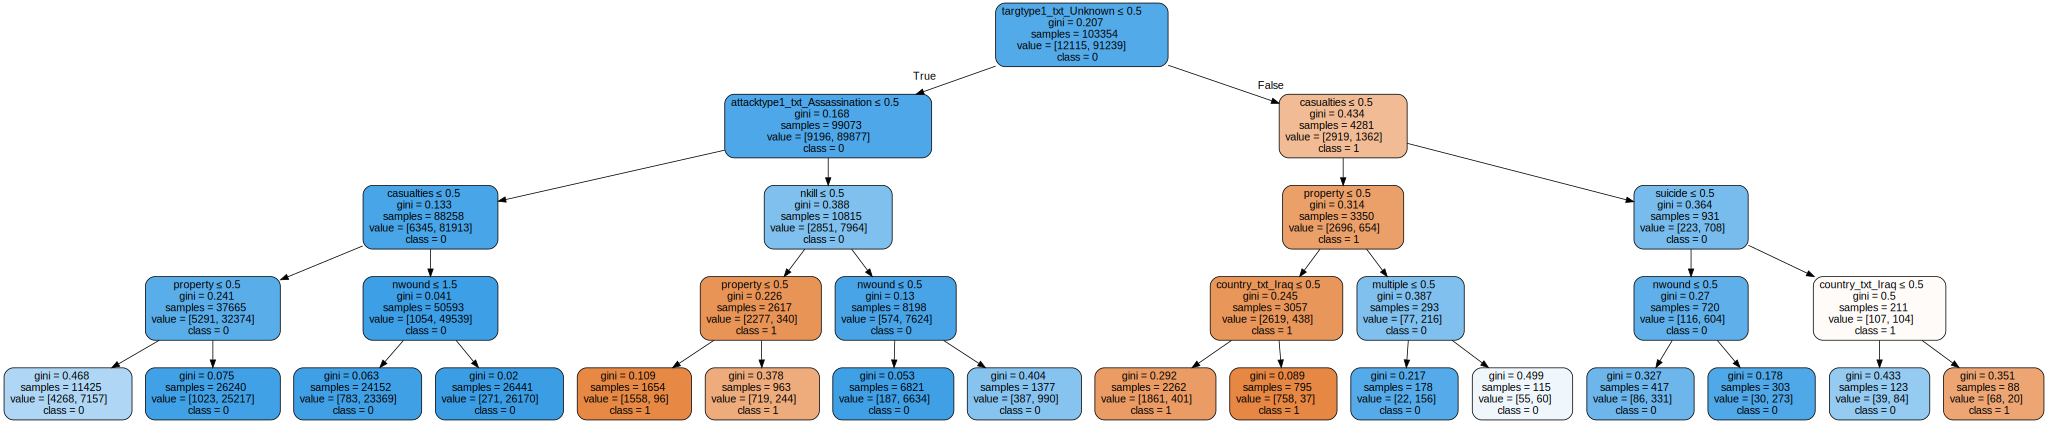

In [41]:
import graphviz
tree_clf = create_decision_tree_classifier(4, X_train, y_train)
data = export_graphviz(tree_clf, 
                out_file=None,  
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = list(X.columns),
                class_names=['1','0'])

graph = graphviz.Source(data)
graph